<a href="https://colab.research.google.com/github/Tepuy-A/Tesis-2/blob/main/Ising_LogReg_prueba_7_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sin validación
GPU HIGH RAM T4


*   Batch size = ?
*   Epoch = 50
*   Opt = SGD
*   learning_rates = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
*   N_neurons = [1, 10, 100, 1000]


    
    

In [1]:
# Importa las bibliotecas necesarias

import numpy as np
import pickle, os
from urllib.request import urlopen
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker

from sklearn import linear_model
from sklearn.neural_network import MLPClassifier

import time

In [2]:
# Define la URL del conjunto de datos y los nombres de los archivos
url_main = 'https://physics.bu.edu/~pankajm/ML-Review-Datasets/isingMC/';
data_file_name = "Ising2DFM_reSample_L40_T=All.pkl"
label_file_name = "Ising2DFM_reSample_L40_T=All_labels.pkl"

# Carga los datos y las etiquetas desde los archivos
data = pickle.load(urlopen(url_main + data_file_name))
data = np.unpackbits(data).reshape(-1, 1600) # Reformatea los datos
data=data.astype('int') # Convierte los datos a enteros
data[np.where(data==0)]=-1 # Cambia los 0 a -1


labels = pickle.load(urlopen(url_main + label_file_name))

In [3]:
# Divide los datos en conjuntos ordenados, críticos y desordenados
X_ordered=data[:70000,:]
Y_ordered=labels[:70000]

X_critical=data[70000:100000,:]
Y_critical=labels[70000:100000]

X_disordered=data[100000:,:]
Y_disordered=labels[100000:]

del data,labels # Libera memoria

# Crea conjuntos de entrenamiento y prueba combinando datos ordenados y desordenados
X=np.concatenate((X_ordered,X_disordered))
Y=np.concatenate((Y_ordered,Y_disordered))

# Divide en conjuntos de entrenamiento y prueba
X_train,X_test,Y_train,Y_test=train_test_split(X,Y, test_size=0.2, train_size=0.8, random_state=44)

# PRIMERA ETAPA

In [4]:
def evaluate_model(lr, lmbda):

    """
    Evalúa un modelo de regresión logística basado en SGD con los parámetros dados.

    Parámetros:
    lr (float): Tasa de aprendizaje.
    lmbda (float): Parámetro de regularización.

    Retorna:
    tuple: Precisión en entrenamiento, precisión en prueba, precisión en datos críticos,
           tiempo promedio por época y tiempo total de entrenamiento.
    """
    # Define el modelo de regresión logística basado en SGD
    logreg_SGD_1 = linear_model.SGDClassifier(
        loss='log_loss',         # Utiliza la función de pérdida log-loss (logistic loss)
        penalty='l2',            # Aplica penalización L2 (Ridge)
        alpha=lmbda,             # Parámetro de regularización
        max_iter=100,            # Número máximo de iteraciones
        shuffle=True,            # Barajar los datos después de cada época
        random_state=42,          # Semilla para reproducibilidad
        learning_rate='constant',# Tasa de aprendizaje constante
        eta0=lr,                 # Valor inicial de la tasa de aprendizaje
        verbose=1                # Mostrar información de entrenamiento
    )

    # Ajusta el modelo con los datos de entrenamiento y mide el tiempo de entrenamiento
    start_time_1 = time.time()  # Registrar el tiempo de inicio
    logreg_SGD_1.fit(X_train,Y_train)
    training_time_1 = time.time() - start_time_1  # Calcular el tiempo de entrenamiento

    # Obtiene el número de épocas utilizadas
    n_epochs = logreg_SGD_1.n_iter_

    # Calcula el tiempo promedio por época
    avg_epoch_time_1 = training_time_1 / n_epochs
    print(f'Tiempo promedio por época: {avg_epoch_time_1} segundos')


    # Calcula la precisión en los datos de entrenamiento
    train_accuracy_1=logreg_SGD_1.score(X_train,Y_train)
    # Calcula la precisión en los datos de prueba
    test_accuracy_1=logreg_SGD_1.score(X_test,Y_test)
    # Calcula la precisión en los datos críticos (datos adicionales para evaluación)
    critical_accuracy_1=logreg_SGD_1.score(X_critical,Y_critical)

    print(f'Train accuracy: {train_accuracy_1}')
    print(f'Test accuracy: {test_accuracy_1}')
    print(f'Critical accuracy: {critical_accuracy_1}')
    print(f'Training time: {training_time_1} seconds')

    return train_accuracy_1, test_accuracy_1, critical_accuracy_1, avg_epoch_time_1, training_time_1

In [5]:
# Definición de los valores para los parámetros de regularización y tasas de aprendizaje
lambdas = [1e-4, 1e-3, 1e-2, 1e-1, 1e+00, 1e+1, 1e+2, 1e+3, 1e+4]  # Valores de lambda para la regularización
learning_rates = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e+00, 1e+1, 1e+2, 1e+3, 1e+4, 1e+5]  # Valores de tasas de aprendizaje

def grid_search():
    """
    Realiza una búsqueda en malla (grid search) sobre los parámetros de regularización y tasa de aprendizaje.

    Retorna:
    dict: Un diccionario con los resultados para cada combinación de parámetros.
    """
    results = {}  # Diccionario para almacenar los resultados

    # Itera sobre cada valor de lambda
    for lmbda in lambdas:
        # Itera sobre cada valor de tasa de aprendizaje
        for lr in learning_rates:
            print(f'Training with lambda = {lmbda} and SGD lr={lr}')  # Muestra el estado actual del entrenamiento

            # Evalúa el modelo con los parámetros actuales
            train_accuracy_1, test_accuracy_1, critical_accuracy_1, avg_epoch_time_1, training_time_1 = evaluate_model(lr, lmbda)

            # Almacena los resultados en el diccionario
            results[(lmbda, lr)] = {
                'train_accuracy_1': train_accuracy_1,       # Precisión en los datos de entrenamiento
                'test_accuracy_1': test_accuracy_1,         # Precisión en los datos de prueba
                'critical_accuracy_1': critical_accuracy_1, # Precisión en los datos críticos
                'avg_epoch_time_1': avg_epoch_time_1,       # Tiempo promedio por época
                'training_time_1': training_time_1          # Tiempo total de entrenamiento
            }

    return results  # Retorna el diccionario con los resultados

In [6]:
# Ejecutar grid_search y guardar los resultados
results = grid_search()

Training with lambda = 0.0001 and SGD lr=1e-05
-- Epoch 1
Norm: 0.04, NNZs: 1600, Bias: 0.035769, T: 104000, Avg. loss: 0.693018
Total training time: 0.36 seconds.
-- Epoch 2
Norm: 0.08, NNZs: 1600, Bias: 0.064109, T: 208000, Avg. loss: 0.690759
Total training time: 0.71 seconds.
-- Epoch 3
Norm: 0.11, NNZs: 1600, Bias: 0.086282, T: 312000, Avg. loss: 0.689038
Total training time: 1.07 seconds.
-- Epoch 4
Norm: 0.13, NNZs: 1600, Bias: 0.104132, T: 416000, Avg. loss: 0.687889
Total training time: 1.42 seconds.
-- Epoch 5
Norm: 0.16, NNZs: 1600, Bias: 0.118273, T: 520000, Avg. loss: 0.686901
Total training time: 1.78 seconds.
-- Epoch 6
Norm: 0.18, NNZs: 1600, Bias: 0.129601, T: 624000, Avg. loss: 0.686183
Total training time: 2.14 seconds.
-- Epoch 7
Norm: 0.20, NNZs: 1600, Bias: 0.138785, T: 728000, Avg. loss: 0.685679
Total training time: 2.49 seconds.
-- Epoch 8
Norm: 0.22, NNZs: 1600, Bias: 0.146315, T: 832000, Avg. loss: 0.685219
Total training time: 2.85 seconds.
-- Epoch 9
Norm: 

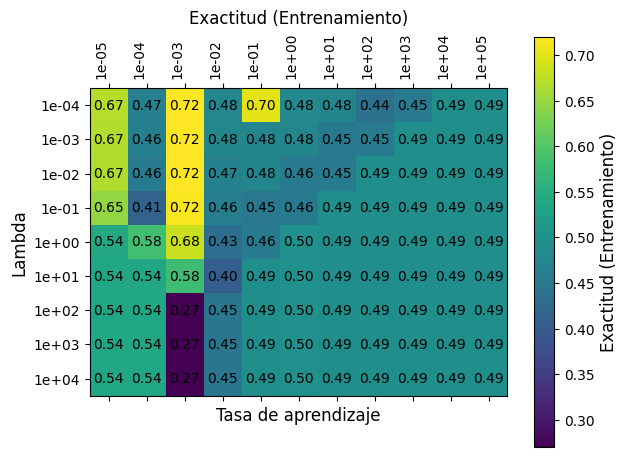

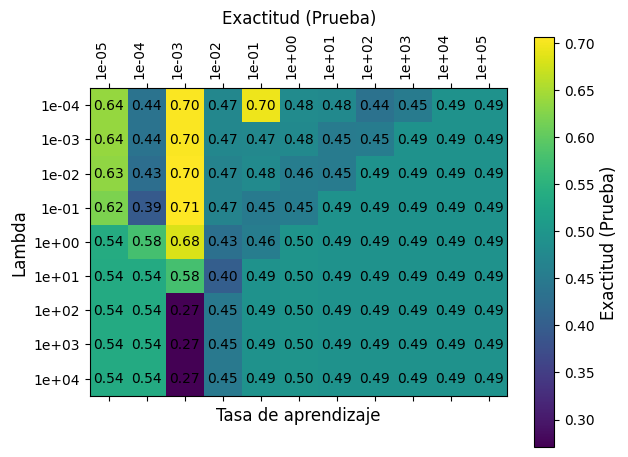

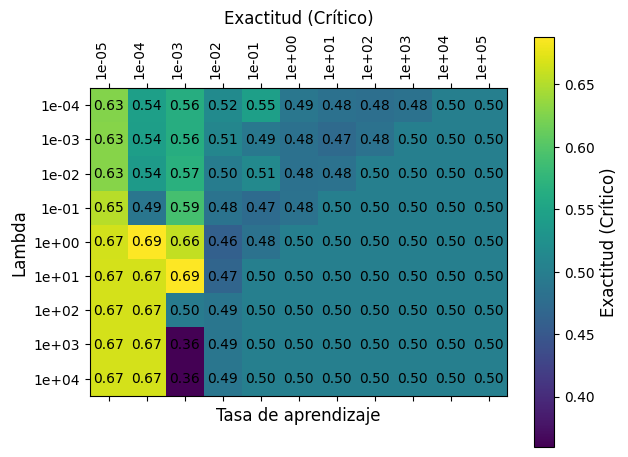

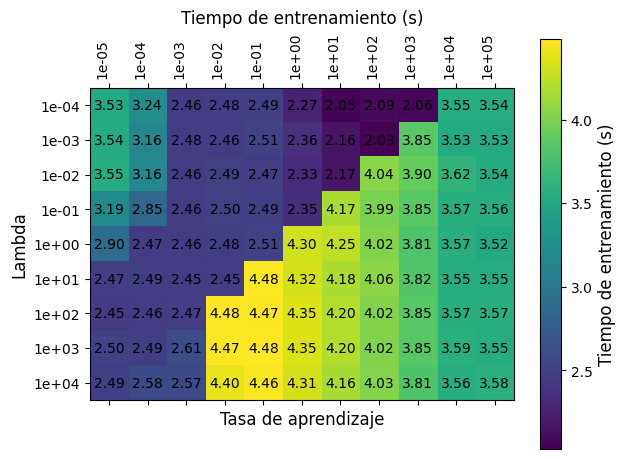

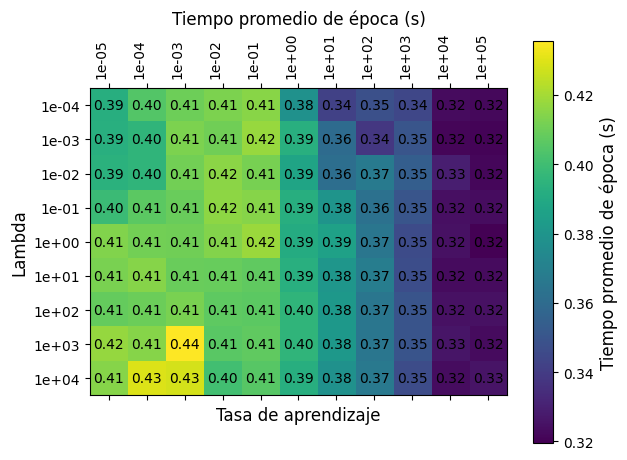

In [7]:
def extract_data(results, metric):
    """
    Extrae los datos de una métrica específica del diccionario de resultados.

    Parámetros:
    results (dict): Diccionario con los resultados de la búsqueda en malla.
    metric (str): Métrica a extraer (por ejemplo, 'train_accuracy', 'test_accuracy').

    Retorna:
    tuple: Tasas de aprendizaje, lambdas y matriz de datos con la métrica especificada.
    """
    lambdas = sorted(set(key[0] for key in results.keys()))  # Obtener y ordenar los valores únicos de lambda
    learning_rates = sorted(set(key[1] for key in results.keys()))  # Obtener y ordenar los valores únicos de tasa de aprendizaje
    data_matrix = np.zeros((len(lambdas), len(learning_rates)))  # Crear una matriz para almacenar los datos

    # Llenar la matriz con los valores de la métrica especificada
    for i, lmbda in enumerate(lambdas):
        for j, lr in enumerate(learning_rates):
            data_matrix[i, j] = results[(lmbda, lr)][metric]

    return learning_rates, lambdas, data_matrix  # Retornar los valores de tasas de aprendizaje, lambdas y la matriz de datos

def plot_data(x, y, data, title=None):
    """
    Grafica los datos en una matriz de calor.

    Parámetros:
    x (list): Valores del eje x (tasas de aprendizaje).
    y (list): Valores del eje y (lambdas).
    data (ndarray): Matriz de datos a graficar.
    title (str): Título del gráfico.
    """
    fig = plt.figure()  # Crear una nueva figura
    ax = fig.add_subplot(111)  # Añadir un subplot a la figura
    cax = ax.matshow(data, interpolation='nearest', aspect=0.9)  # Crear un mapa de calor de los datos

    cbar = fig.colorbar(cax)  # Añadir una barra de color a la figura
    if title:
        cbar.ax.set_ylabel(title, rotation=90, fontsize=12)  # Añadir título a la barra de color

    # Añadir los valores de la matriz en el gráfico
    for i, x_val in enumerate(np.arange(len(x))):
        for j, y_val in enumerate(np.arange(len(y))):
            c = f"{data[j, i]:.2f}"
            ax.text(x_val, y_val, c, va='center', ha='center')

    # Convertir los elementos de x a cadenas individualmente
    x_labels = [str(i) for i in x]
    y_labels = [str(i) for i in y]

    ax.set_xticks(np.arange(len(x)), labels=x_labels, rotation=90, ha='right')  # Usar la lista de etiquetas de cadenas
    ax.set_yticks(np.arange(len(y)), labels=y_labels)

    # Formatear las etiquetas del eje x en notación científica
    # Convertir los valores de x a cadenas en formato científico
    x_labels_formatted = ['{:.0e}'.format(val) for val in x]
    ax.set_xticks(np.arange(len(x)), labels=x_labels_formatted)

    # Formatear las etiquetas del eje y en notación científica
    y_labels_formatted = ['{:.0e}'.format(val) for val in y]
    ax.set_yticks(np.arange(len(y)), labels=y_labels_formatted)


    ax.set_xlabel('Tasa de aprendizaje', fontsize=12)  # Etiqueta del eje x
    ax.set_ylabel('Lambda', fontsize=12)  # Etiqueta del eje y
    if title is not None:
        ax.set_title(title)  # Título del gráfico si se proporciona

    plt.tight_layout()  # Ajustar el diseño para evitar solapamientos
    plt.show()  # Mostrar el gráfico

# Graficar los resultados para cada métrica
for metric in ['train_accuracy_1', 'test_accuracy_1', 'critical_accuracy_1']:
    learning_rates, lambdas, data_matrix = extract_data(results, metric)  # Extraer los datos de la métrica actual

    # Cambiar los títulos de los gráficos
    if metric == 'train_accuracy_1':
        title = 'Exactitud (Entrenamiento)'
    elif metric == 'test_accuracy_1':
        title = 'Exactitud (Prueba)'
    elif metric == 'critical_accuracy_1':
        title = 'Exactitud (Crítico)'


    plot_data(learning_rates, lambdas, data_matrix, title=title)  # Graficar los datos

# Graficar el tiempo de entrenamiento
learning_rates, lambdas, training_time_matrix = extract_data(results, 'training_time_1')  # Extraer los datos del tiempo de entrenamiento
plot_data(learning_rates, lambdas, training_time_matrix, title='Tiempo de entrenamiento (s)')  # Graficar el tiempo de entrenamiento

# Graficar el tiempo promedio por época
learning_rates, lambdas, avg_epoch_time_matrix = extract_data(results, 'avg_epoch_time_1')  # Extraer los datos del tiempo promedio por época
plot_data(learning_rates, lambdas, avg_epoch_time_matrix, title='Tiempo promedio de época (s)')  # Graficar el tiempo promedio por época

A partir de los resultados obtenidos en los gráficos se determina que el mejor valor de la tasa de aprendizaje corresponde a 1e-3, ya que para este valor se obtienen los mejores resultados de exactitud para los tres conjuntos de datos.

In [8]:
import psutil
import os
import resource

def get_memory_usage():
    process = psutil.Process(os.getpid())
    memory_info = process.memory_info()
    return {
        'rss': memory_info.rss,
        'vms': memory_info.vms,
        'shared': memory_info.shared,
        'text': memory_info.text,
        'lib': memory_info.lib,
        'data': memory_info.data,
        'dirty': memory_info.dirty
    }

def get_disk_usage():
    disk_usage = psutil.disk_usage('/')
    return {
        'total': disk_usage.total,
        'used': disk_usage.used,
        'free': disk_usage.free,
        'percent': disk_usage.percent
    }

def get_cpu_usage():
    cpu_usage = psutil.cpu_percent(interval=1)
    return {
        'cpu_percent': cpu_usage
    }

def get_resource_usage():
    resource_usage = resource.getrusage(resource.RUSAGE_SELF)
    return {
        'utime': resource_usage.ru_utime,
        'stime': resource_usage.ru_stime,
        'maxrss': resource_usage.ru_maxrss,
        'ixrss': resource_usage.ru_ixrss,
        'idrss': resource_usage.ru_idrss,
        'isrss': resource_usage.ru_isrss,
        'minflt': resource_usage.ru_minflt,
        'majflt': resource_usage.ru_majflt,
        'nswap': resource_usage.ru_nswap,
        'inblock': resource_usage.ru_inblock,
        'oublock': resource_usage.ru_oublock,
        'msgsnd': resource_usage.ru_msgsnd,
        'msgrcv': resource_usage.ru_msgrcv,
        'nsignals': resource_usage.ru_nsignals,
        'nvcsw': resource_usage.ru_nvcsw,
        'nivcsw': resource_usage.ru_nivcsw
    }

print("Memory Usage:", get_memory_usage())
print("Disk Usage:", get_disk_usage())
print("CPU Usage:", get_cpu_usage())
print("Resource Usage:", get_resource_usage())


Memory Usage: {'rss': 5555200000, 'vms': 7225860096, 'shared': 49455104, 'text': 2818048, 'lib': 0, 'data': 6259879936, 'dirty': 0}
Disk Usage: {'total': 242486079488, 'used': 29356617728, 'free': 213112684544, 'percent': 12.1}
CPU Usage: {'cpu_percent': 1.8}
Resource Usage: {'utime': 397.82356, 'stime': 193.792604, 'maxrss': 6709108, 'ixrss': 0, 'idrss': 0, 'isrss': 0, 'minflt': 376954, 'majflt': 0, 'nswap': 0, 'inblock': 0, 'oublock': 8, 'msgsnd': 0, 'msgrcv': 0, 'nsignals': 0, 'nvcsw': 25444, 'nivcsw': 1310501}


In [9]:
print(results)

{(0.0001, 1e-05): {'train_accuracy_1': 0.6688461538461539, 'test_accuracy_1': 0.6366923076923077, 'critical_accuracy_1': 0.6275, 'avg_epoch_time_1': 0.3923817210727268, 'training_time_1': 3.531435489654541}, (0.0001, 0.0001): {'train_accuracy_1': 0.46566346153846155, 'test_accuracy_1': 0.43688461538461537, 'critical_accuracy_1': 0.5446666666666666, 'avg_epoch_time_1': 0.4045938551425934, 'training_time_1': 3.236750841140747}, (0.0001, 0.001): {'train_accuracy_1': 0.7196730769230769, 'test_accuracy_1': 0.7033461538461538, 'critical_accuracy_1': 0.5636, 'avg_epoch_time_1': 0.40992101033528644, 'training_time_1': 2.4595260620117188}, (0.0001, 0.01): {'train_accuracy_1': 0.47852884615384617, 'test_accuracy_1': 0.47292307692307695, 'critical_accuracy_1': 0.5168333333333334, 'avg_epoch_time_1': 0.41276152928670246, 'training_time_1': 2.476569175720215}, (0.0001, 0.1): {'train_accuracy_1': 0.7010096153846154, 'test_accuracy_1': 0.6952307692307692, 'critical_accuracy_1': 0.5451, 'avg_epoch_tim

In [10]:
# results =

# SEGUNDA ETAPA

In [17]:
# Define el parámetro de regularización
lmbdas=np.logspace(-5,5,11)

# Preasigna espacio para los datos de precisión
train_accuracy_SGD_2=np.zeros(lmbdas.shape,np.float64)
val_accuracy_SGD_2=np.zeros(lmbdas.shape,np.float64)
critical_accuracy_SGD_2=np.zeros(lmbdas.shape,np.float64)

# Itera sobre cada valor de regularización
for i,lmbda in enumerate(lmbdas):

    print('Training with lambda = ', lmbda)

    # Define el modelo de regresión logística basado en SGD
    logreg_SGD_2 = linear_model.SGDClassifier(
        loss='log_loss',         # Función de pérdida de log-loss
        penalty='l2',            # Penalización L2 (Ridge)
        alpha=lmbda,             # Parámetro de regularización
        max_iter=100,            # Número máximo de iteraciones
        shuffle=True,            # Barajar datos después de cada época
        random_state=42,        # Semilla para reproducibilidad
        learning_rate='constant',# Tasa de aprendizaje constante
        eta0=1e-3,               # Valor inicial de la tasa de aprendizaje
        verbose=1                # Mostrar información de entrenamiento
    )

    # Ajusta el modelo con los datos de entrenamiento y mide el tiempo de entrenamiento
    start_time_2 = time.time()  # Registrar el tiempo de inicio
    logreg_SGD_2.fit(X_train,Y_train)
    end_time_2 = time.time()  # Registrar el tiempo de finalización
    training_time_2 = end_time_2 - start_time_2  # Calcular el tiempo de entrenamiento

    # Calcula la precisión en los datos de entrenamiento y validación
    train_accuracy_SGD_2[i]=logreg_SGD_2.score(X_train,Y_train)
    val_accuracy_SGD_2[i]=logreg_SGD_2.score(X_test, Y_test)

    print(f'Tiempo de entrenamiento: {training_time_2} segundos')
    print('SGD: %0.4f, %0.4f' %(train_accuracy_SGD_2[i],val_accuracy_SGD_2[i]) )
    print('finished computing %i/11 iterations' %(i+1))

Training with lambda =  1e-05
-- Epoch 1
Norm: 1.18, NNZs: 1600, Bias: 0.229270, T: 104000, Avg. loss: 0.814815
Total training time: 0.42 seconds.
-- Epoch 2
Norm: 1.15, NNZs: 1600, Bias: 0.213574, T: 208000, Avg. loss: 0.820647
Total training time: 0.83 seconds.
-- Epoch 3
Norm: 1.18, NNZs: 1600, Bias: 0.152112, T: 312000, Avg. loss: 0.817474
Total training time: 1.24 seconds.
-- Epoch 4
Norm: 1.21, NNZs: 1600, Bias: 0.239227, T: 416000, Avg. loss: 0.818077
Total training time: 1.63 seconds.
-- Epoch 5
Norm: 1.18, NNZs: 1600, Bias: 0.183949, T: 520000, Avg. loss: 0.820396
Total training time: 2.01 seconds.
-- Epoch 6
Norm: 1.18, NNZs: 1600, Bias: 0.214709, T: 624000, Avg. loss: 0.818722
Total training time: 2.39 seconds.
Convergence after 6 epochs took 2.39 seconds
Tiempo de entrenamiento: 2.731740951538086 segundos
SGD: 0.7197, 0.7033
finished computing 1/11 iterations
Training with lambda =  0.0001
-- Epoch 1
Norm: 1.18, NNZs: 1600, Bias: 0.229249, T: 104000, Avg. loss: 0.814745
Tot

In [18]:
print(train_accuracy_SGD_2)
print(val_accuracy_SGD_2)

[0.71966346 0.71967308 0.71972115 0.71961538 0.71553846 0.68306731
 0.58009615 0.27039423 0.27075    0.27075    0.27075   ]
[0.70334615 0.70334615 0.70334615 0.70488462 0.70623077 0.6815
 0.57746154 0.27080769 0.271      0.271      0.271     ]


In [1]:
train_accuracy_SGD_2 =[0.71966346, 0.71967308 ,0.71972115, 0.71961538, 0.71553846, 0.68306731, 0.58009615, 0.27039423, 0.27075, 0.27075 , 0.27075 ]
val_accuracy_SGD_2 =[0.70334615, 0.70334615, 0.70334615, 0.70488462, 0.70623077, 0.6815, 0.57746154, 0.27080769, 0.271, 0.271, 0.271 ]

In [19]:
best_train_index_2 = np.argmax(train_accuracy_SGD_2)
best_val_index_2 = np.argmax(val_accuracy_SGD_2)

best_lambda_train = lmbdas[best_train_index_2]
best_lambda_val = lmbdas[best_val_index_2]

print(f"Mejor exactitud (entrenamiento) = {train_accuracy_SGD_2[best_train_index_2]}, con lambda = {best_lambda_train}")
print(f"Mejor exactitud (prueba) = {val_accuracy_SGD_2[best_val_index_2]}, con lambda =  {best_lambda_val}")

Mejor exactitud (entrenamiento) = 0.7197211538461539, con lambda = 0.001
Mejor exactitud (prueba) = 0.7062307692307692, con lambda =  0.1


In [26]:
print(f"Exactitud (entrenamiento) para lambda = {best_lambda_val} :  {train_accuracy_SGD_2[best_val_index_2]}")

Exactitud (entrenamiento) para lambda = 0.1 :  0.7155384615384616


Se decide escoger lambda = 0.1 porque para este valor de regularización se obtienen buenos resultados de la exactitud (Entrenamiento 71.55% y Prueba 70.62%) para los dos conjuntos de datos, y estos resultados son consistentes con los resultados usuales en la implementación de un modelo de clasificación usando regresión logística, en donde se espera que la generalización del modelo ante datos no vistos (datos de prueba) sea igual o menor que los resultados para los datos de etrenamiento. El porcentaje de sobreajuste obtenido es del 1.3%, lo cual es una cantidad aceptable.



In [30]:
chosen_lambda = best_lambda_val

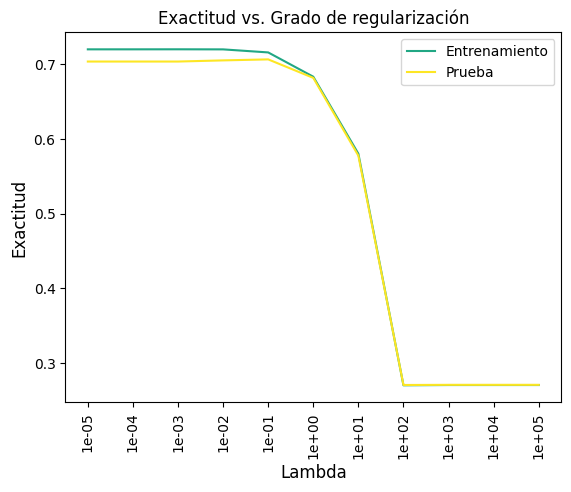

In [6]:
# Gráfico de la precisión del modelo para los distintos valores de regularización, para el conjunto de datos de entrenamiento y prueba
lambdas= [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e+00, 1e+1, 1e+2, 1e+3, 1e+4, 1e+5]

plt.xscale('log')  # Establece la escala logarítmica en el eje x
plt.xticks(lambdas, [f'{lmbda:.0e}' for lmbda in lambdas])  # Formatea las etiquetas de los ticks
plt.xticks(rotation=90)

plt.plot(lambdas,train_accuracy_SGD_2,'#21a784', label='Entrenamiento')
plt.plot(lambdas,val_accuracy_SGD_2,'#fde624', label='Prueba')

plt.xlabel('Lambda', fontsize = 12)
plt.ylabel('Exactitud', fontsize = 12)
plt.title("Exactitud vs. Grado de regularización")


plt.legend()
plt.show()

# MEJOR MODELO

In [28]:
# Define el modelo de regresión logística basado en SGD utilizando lambda = 0.1
logreg_SGD_best = linear_model.SGDClassifier(loss='log_loss',
                                             penalty='l2',
                                             alpha=chosen_lambda,
                                             max_iter=100,
                                             shuffle=True,
                                             random_state=42,
                                             learning_rate='constant',
                                             eta0 = 1e-03,
                                             verbose = 1)

# Ajusta el modelo con los datos de entrenamiento
start_time_best = time.time()
logreg_SGD_best.fit(X_train,Y_train)
training_time_best = time.time() - start_time_best


train_accuracy_SGD_best=logreg_SGD_best.score(X_train,Y_train)             # Calcula la precisión en los datos de entrenamiento
val_accuracy_SGD_best=logreg_SGD_best.score(X_test, Y_test)                  # Calcula la precisión en los datos de prueba
critical_accuracy_SGD_best=logreg_SGD_best.score(X_critical,Y_critical)    # Calcula la precisión en los datos críticos

-- Epoch 1
Norm: 0.73, NNZs: 1600, Bias: 0.219904, T: 104000, Avg. loss: 0.783658
Total training time: 0.36 seconds.
-- Epoch 2
Norm: 0.72, NNZs: 1600, Bias: 0.209544, T: 208000, Avg. loss: 0.786377
Total training time: 0.72 seconds.
-- Epoch 3
Norm: 0.73, NNZs: 1600, Bias: 0.144130, T: 312000, Avg. loss: 0.784082
Total training time: 1.07 seconds.
-- Epoch 4
Norm: 0.74, NNZs: 1600, Bias: 0.220262, T: 416000, Avg. loss: 0.784692
Total training time: 1.43 seconds.
-- Epoch 5
Norm: 0.72, NNZs: 1600, Bias: 0.173203, T: 520000, Avg. loss: 0.786526
Total training time: 1.79 seconds.
-- Epoch 6
Norm: 0.72, NNZs: 1600, Bias: 0.206799, T: 624000, Avg. loss: 0.785291
Total training time: 2.14 seconds.
Convergence after 6 epochs took 2.14 seconds


In [39]:
print(f'Tiempo de entrenamiento para logreg_SGD_best: {training_time_best} segundos')
print('Exactitud (entrenamiento) =', train_accuracy_SGD_best )
print('Exactitud (prueba) =', val_accuracy_SGD_best )
print('Exactitud (crítico) =', critical_accuracy_SGD_best )

Tiempo de entrenamiento para logreg_SGD_best: 3.13000750541687 segundos
Exactitud (entrenamiento) = 0.7155384615384616
Exactitud (prueba) = 0.7062307692307692
Exactitud (crítico) = 0.5910666666666666


In [23]:
def calcular_sobreajuste(train_accuracy, test_accuracy):
  """Calcula el porcentaje de sobreajuste.

  Args:
    train_accuracy: Precisión en los datos de entrenamiento.
    test_accuracy: Precisión en los datos de prueba o críticos.

  Returns:
    El porcentaje de sobreajuste.
  """
  overfitting = (train_accuracy - test_accuracy) / train_accuracy * 100
  return overfitting

In [36]:
sobreajuste_test = calcular_sobreajuste(train_accuracy_SGD_best, val_accuracy_SGD_best)
sobreajuste_critico = calcular_sobreajuste(train_accuracy_SGD_best, critical_accuracy_SGD_best)

print(f"Porcentaje de sobreajuste (prueba): {sobreajuste_test:.2f}%")
print(f"Porcentaje de sobreajuste (crítico): {sobreajuste_critico:.2f}%")

Porcentaje de sobreajuste (prueba): 1.30%
Porcentaje de sobreajuste (crítico): 17.40%


# PRUEBA ADICIONAL

In [31]:
print(f"Mejor exactitud (entrenamiento) = {train_accuracy_SGD_2[best_train_index_2]}, con lambda = {best_lambda_train}")
print(f"Exactitud (prueba) para lambda = {best_lambda_train} :  {val_accuracy_SGD_2[best_train_index_2]}")

Mejor exactitud (entrenamiento) = 0.7197211538461539, con lambda = 0.001
Exactitud (prueba) para lambda = 0.001 :  0.7033461538461538


In [32]:
chosen_lambda_2 = best_lambda_train

In [33]:
# Define el modelo de regresión logística basado en SGD utilizando lambda = 0.1
logreg_SGD_pruebaadicional = linear_model.SGDClassifier(loss='log_loss',
                                             penalty='l2',
                                             alpha=chosen_lambda_2,
                                             max_iter=100,
                                             shuffle=True,
                                             random_state=42,
                                             learning_rate='constant',
                                             eta0 = 1e-03,
                                             verbose = 1)

# Ajusta el modelo con los datos de entrenamiento
start_time_pruebaadicional = time.time()
logreg_SGD_pruebaadicional.fit(X_train,Y_train)
training_time_pruebaadicional = time.time() - start_time_pruebaadicional


train_accuracy_SGD_pruebaadicional=logreg_SGD_pruebaadicional.score(X_train,Y_train)             # Calcula la precisión en los datos de entrenamiento
val_accuracy_SGD_pruebaadicional=logreg_SGD_pruebaadicional.score(X_test, Y_test)                  # Calcula la precisión en los datos de prueba
critical_accuracy_SGD_pruebaadicional=logreg_SGD_pruebaadicional.score(X_critical,Y_critical)    # Calcula la precisión en los datos críticos

-- Epoch 1
Norm: 1.17, NNZs: 1600, Bias: 0.229042, T: 104000, Avg. loss: 0.814063
Total training time: 0.36 seconds.
-- Epoch 2
Norm: 1.14, NNZs: 1600, Bias: 0.213451, T: 208000, Avg. loss: 0.819741
Total training time: 0.72 seconds.
-- Epoch 3
Norm: 1.16, NNZs: 1600, Bias: 0.151870, T: 312000, Avg. loss: 0.816576
Total training time: 1.08 seconds.
-- Epoch 4
Norm: 1.20, NNZs: 1600, Bias: 0.238753, T: 416000, Avg. loss: 0.817176
Total training time: 1.47 seconds.
-- Epoch 5
Norm: 1.17, NNZs: 1600, Bias: 0.183664, T: 520000, Avg. loss: 0.819485
Total training time: 1.83 seconds.
-- Epoch 6
Norm: 1.17, NNZs: 1600, Bias: 0.214551, T: 624000, Avg. loss: 0.817828
Total training time: 2.21 seconds.
Convergence after 6 epochs took 2.21 seconds


In [37]:
print(f'Tiempo de entrenamiento para logreg_SGD_pruebaadicional: {training_time_pruebaadicional} segundos')
print('Exactitud (entrenamiento) =', train_accuracy_SGD_pruebaadicional )
print('Exactitud  (prueba)=', val_accuracy_SGD_pruebaadicional )
print('Exactitud (critica) =', critical_accuracy_SGD_pruebaadicional )

Tiempo de entrenamiento para logreg_SGD_pruebaadicional: 2.6196906566619873 segundos
Exactitud (entrenamiento) = 0.7197211538461539
Exactitud  (prueba)= 0.7033461538461538
Exactitud (critica) = 0.5638333333333333


In [38]:
sobreajuste_test = calcular_sobreajuste(train_accuracy_SGD_pruebaadicional, val_accuracy_SGD_pruebaadicional)
sobreajuste_critico = calcular_sobreajuste(train_accuracy_SGD_pruebaadicional, critical_accuracy_SGD_pruebaadicional)

print(f"Porcentaje de sobreajuste (prueba): {sobreajuste_test:.2f}%")
print(f"Porcentaje de sobreajuste (crítico): {sobreajuste_critico:.2f}%")

Porcentaje de sobreajuste (prueba): 2.28%
Porcentaje de sobreajuste (crítico): 21.66%


# REGRESIÓN LOGÍSTICA SIN REGULARIZACIÓN

In [7]:
# Definición de los valores para los parámetros de regularización y tasas de aprendizaje
learning_rates = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e+00, 1e+1, 1e+2, 1e+3, 1e+4, 1e+5]  # Valores de tasas de aprendizaje

def grid_search_2():
    """
    Realiza una búsqueda en malla (grid search) sobre el parametro de tasa de aprendizaje.

    Retorna:
    dict: Un diccionario con los resultados para cada valor de tasa de aprendizaje.
    """
    results = {}  # Diccionario para almacenar los resultados


      # Itera sobre cada valor de tasa de aprendizaje
    for lr in learning_rates:
          print(f'Entrenando con lr={lr}')  # Muestra el estado actual del entrenamiento
          # Evalúa el modelo con los parámetros actuales
          train_accuracy_1, test_accuracy_1, critical_accuracy_1, avg_epoch_time_1, training_time_1 = evaluate_model(lr, lmbda = 0)
          # Almacena los resultados en el diccionario
          results[lr] = {
              'train_accuracy_1': train_accuracy_1,       # Precisión en los datos de entrenamiento
              'test_accuracy_1': test_accuracy_1,         # Precisión en los datos de prueba
              'critical_accuracy_1': critical_accuracy_1, # Precisión en los datos críticos
              'avg_epoch_time_1': avg_epoch_time_1,       # Tiempo promedio por época
              'training_time_1': training_time_1          # Tiempo total de entrenamiento
          }

    return results  # Retorna el diccionario con los resultados

In [14]:
results_3 = grid_search_2()

Entrenando con lr=1e-05
-- Epoch 1
Norm: 0.04, NNZs: 1600, Bias: 0.035769, T: 104000, Avg. loss: 0.693018
Total training time: 0.37 seconds.
-- Epoch 2
Norm: 0.08, NNZs: 1600, Bias: 0.064109, T: 208000, Avg. loss: 0.690759
Total training time: 0.73 seconds.
-- Epoch 3
Norm: 0.11, NNZs: 1600, Bias: 0.086283, T: 312000, Avg. loss: 0.689038
Total training time: 1.11 seconds.
-- Epoch 4
Norm: 0.13, NNZs: 1600, Bias: 0.104132, T: 416000, Avg. loss: 0.687888
Total training time: 1.48 seconds.
-- Epoch 5
Norm: 0.16, NNZs: 1600, Bias: 0.118274, T: 520000, Avg. loss: 0.686901
Total training time: 1.85 seconds.
-- Epoch 6
Norm: 0.18, NNZs: 1600, Bias: 0.129602, T: 624000, Avg. loss: 0.686182
Total training time: 2.20 seconds.
-- Epoch 7
Norm: 0.20, NNZs: 1600, Bias: 0.138787, T: 728000, Avg. loss: 0.685678
Total training time: 2.56 seconds.
-- Epoch 8
Norm: 0.22, NNZs: 1600, Bias: 0.146318, T: 832000, Avg. loss: 0.685218
Total training time: 2.92 seconds.
-- Epoch 9
Norm: 0.24, NNZs: 1600, Bias:

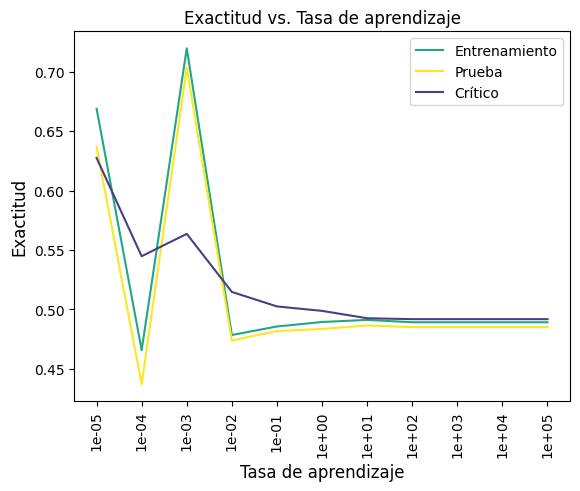

In [15]:
# Extraer datos de resultados
train_accuracy = [results_3[lr]['train_accuracy_1'] for lr in learning_rates]
test_accuracy = [results_3[lr]['test_accuracy_1'] for lr in learning_rates]
critical_accuracy = [results_3[lr]['critical_accuracy_1'] for lr in learning_rates]

# Graficar resultados
plt.plot(learning_rates, train_accuracy, '#21a784', label='Entrenamiento')
plt.plot(learning_rates, test_accuracy, '#fde624', label='Prueba')
plt.plot(learning_rates, critical_accuracy, '#4b3e84', label='Crítico')

plt.xscale('log')
plt.xticks(learning_rates, [f'{lr:.0e}' for lr in learning_rates])  # Formatea las etiquetas de los ticks
plt.xticks(rotation=90)

plt.xlabel('Tasa de aprendizaje', fontsize = 12)
plt.ylabel('Exactitud', fontsize = 12)
plt.title("Exactitud vs. Tasa de aprendizaje")
plt.legend()
plt.show()


In [22]:
# Inicializa listas para almacenar los valores
#train_accuracies = []
#test_accuracies = []
#critical_accuracies = []
#training_times = []

# Tasa de aprendizaje objetivo
target_lr = 1e-5

# Itera a través de los resultados y extrae los valores correspondientes
for lr, metrics in results_3.items():
    if lr == target_lr:
        train_accuracy_3 = (metrics['train_accuracy_1'])
        test_accuracy_3=(metrics['test_accuracy_1'])
        critical_accuracy_3=(metrics['critical_accuracy_1'])
        training_time=(metrics['training_time_1'])

# Imprime los resultados
print("Para la tasa de aprendizaje 1e-5:")
print("Exactitud de entrenamiento:", train_accuracy_3)
print("Exactitud de prueba:", test_accuracy_3)
print("Exactitud crítica:", critical_accuracy_3)
print("Tiempo de entrenamiento:", training_time)

Para la tasa de aprendizaje 1e-5:
Exactitud de entrenamiento: 0.6688653846153846
Exactitud de prueba: 0.6367692307692308
Exactitud crítica: 0.6274333333333333
Tiempo de entrenamiento: 3.6145756244659424


In [24]:
sobreajuste_test_3 = calcular_sobreajuste(train_accuracy_3, test_accuracy_3)
sobreajuste_critico_3 = calcular_sobreajuste(train_accuracy_3, critical_accuracy_3)

print(f"Porcentaje de sobreajuste (prueba): {sobreajuste_test_3:.2f}%")
print(f"Porcentaje de sobreajuste (crítico): {sobreajuste_critico_3:.2f}%")

Porcentaje de sobreajuste (prueba): 4.80%
Porcentaje de sobreajuste (crítico): 6.19%
